In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import open3d as o3d
%matplotlib widget

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# open a file, where you stored the pickled data
file = open('/home/lucas/Documents/GitLab/dmot/sparse_mapping/segment_track/demo/data_hist.pkl', 'rb')
# file = open('/home/lucas/Documents/GitLab/dmot/sparse_mapping/segment_track/demo/segments_pcd', 'rb')
# dump information to that file
observation_history = pickle.load(file)

# close the file
file.close()

In [ ]:
print(observation_history[0])

In [3]:
tracker = observation_history[0]
segments = tracker.segments

In [4]:
pcd_list = []
pcd_raw_list = []
for seg in tracker.segments + tracker.segment_graveyard:
    seg_points = seg.points
    if seg_points is not None:
        num_pts = seg_points.shape[0]
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(seg_points)
        rand_color = np.random.uniform(0, 1, size=(1,3))
        rand_color = np.repeat(rand_color, num_pts, axis=0)
        pcd.colors = o3d.utility.Vector3dVector(rand_color)
        pcd_list.append(pcd)
        pcd_raw_list.append(seg_points)
o3d.visualization.draw_geometries(pcd_list)

In [5]:
print(len(pcd_list))

55


In [6]:
o3d.visualization.draw_geometries([pcd_list[i] for i in [10, 12, 13, 14, 16, 17]])

In [7]:
data_aggregated = []
for i in [10, 12, 13, 14, 16, 17]:
    data_aggregated.extend(pcd_raw_list[i])
# data = pcd_raw_list[10]pcd_raw_list[11]
data_aggregated = np.array(data_aggregated)
print(data_aggregated.shape)

(6703, 3)


WARNING - 2024-04-22 23:19:55,709 - legend - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


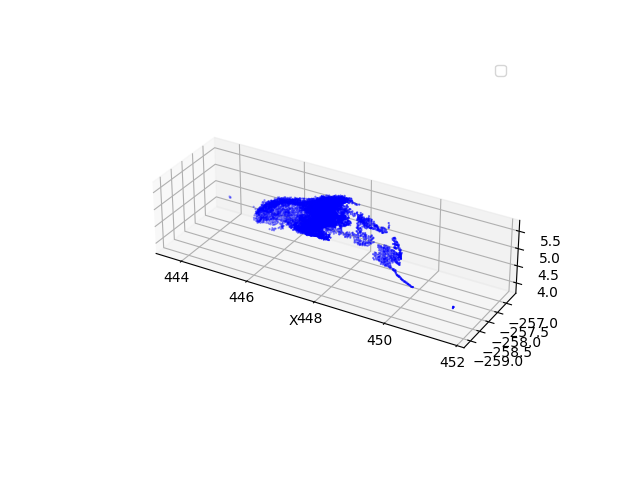

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.scatter(data_aggregated[:, 0], data_aggregated[:, 1], data_aggregated[:, 2], 
            zdir='z', c= 'blue', s=0.3)
ax1.set_aspect('equal')
ax1.set_xlabel("X")
ax1.legend()

In [ ]:
'''
IF loaded from segments_pcd
'''
# dataset = []
# for obs in observation_history:
#     # print(obs["seg_id"])
#     if obs["seg_id"] in [4, 30, 74, 103]:
#         print(obs["seg_id"])
#         dataset.append(obs["seg_pcd"])
# data = dataset[22]

In [9]:
data_processed = np.zeros(data_aggregated.shape)

In [10]:
data_processed[:, 0] = -(data_aggregated[:, 0] - 448)/7
data_processed[:, 1] = (data_aggregated[:, 1] + 257.5)/6
data_processed[:, 2] = (data_aggregated[:, 2] - 5)/6

WARNING - 2024-04-22 23:20:09,862 - legend - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


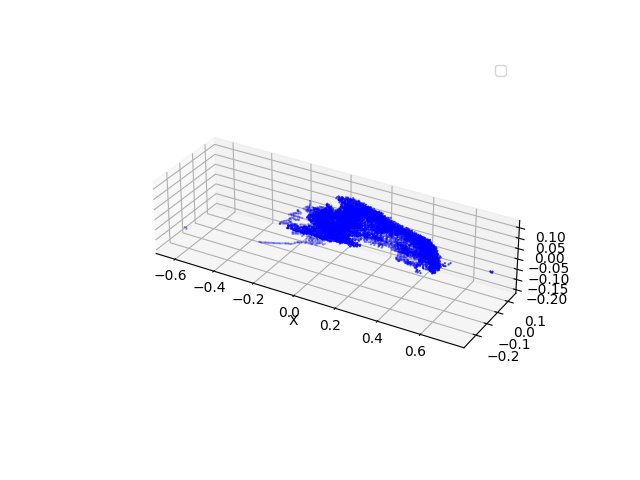

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.scatter(data_processed[:, 0], data_processed[:, 1], data_processed[:, 2], 
            zdir='z', c= 'blue', s=0.3)
ax1.set_aspect('equal')
ax1.set_xlabel("X")
ax1.legend()

In [12]:
import torch
from equiv_reg import misc, config
from equiv_reg.checkpoints import CheckpointIO
from equiv_reg.transforms import apply_rot, gen_randrot
from equiv_reg.register_utils import *
from torch.nn import functional as F

In [13]:
equireg_path = "/home/lucas/Documents/GitLab/dmot/sparse_mapping/equivreg/"
cfg = misc.load_config(equireg_path + 'configs/test/reg_ideal.yaml')

is_cuda = (torch.cuda.is_available())
device = torch.device("cuda" if is_cuda else "cpu")
out_dir, gen_dir = config.cfg_f_out_test(cfg)

model = config.cfg_model(cfg, device)
checkpointio = CheckpointIO(model, checkpoint_dir=out_dir)
checkpointio.load(cfg['testing']['model_file'])

04-22 23:20:29 Hey, logging is written to /home/lucas/Documents/GitLab/dmot/sparse_mapping/equivreg/out/reg/test_ideal/msgs.log!
04-22 23:20:29 cfg is saved at /home/lucas/Documents/GitLab/dmot/sparse_mapping/equivreg/out/reg/test_ideal/cfg.yaml
04-22 23:20:29 {'callback': {'autosave_every': 5000, 'checkpoint_every': 10000, 'print_every': 200, 'validate_every': 3000, 'visualize_every': 0, 'wandb_log_every': 500}, 'checkpoint': {'model_selection_metric': 'angle', 'model_selection_mode': 'minimize'}, 'data': {'input': {'T_file': None, 'categories': ['car'], 'path': '/home/lucas/Documents/GitLab/dmot/sparse_mapping/equivreg/ModelNet40_install', 'pointcloud_file': 'pointcloud.npz'}, 'input_bench': {'T21_file': 'R21.npz', 'path': 'ModelNet40_benchmark', 'pointcloud_file_1': 'pcl_1.npy', 'pointcloud_file_2': 'pcl_2.npy'}, 'occ': {'points_file': 'points.npz', 'points_iou_file': 'points.npz', 'points_subsample': 1024, 'points_unpackbits': True, 'voxels_file': None}, 'test': {'centralize': Fals

/home/lucas/Documents/GitLab/dmot/sparse_mapping/equivreg/out/reg/model_SE3.pt
=> Loading checkpoint from local file...


{'loss_val_best': 6.0864553,
 'it': 300000,
 'epoch_it': 4547,
 'optimizer': {'state': {0: {'step': 300001,
    'exp_avg': tensor([[[-6.9374e-03],
             [-3.2083e-02],
             [ 2.1918e-02],
             ...,
             [-5.2693e-03],
             [ 1.1298e-01],
             [ 2.5141e-01]],
    
            [[-7.3223e-04],
             [ 2.5855e-02],
             [-8.9322e-03],
             ...,
             [-9.2488e-03],
             [ 9.0079e-02],
             [-3.9503e-02]],
    
            [[ 5.0348e-03],
             [-1.2516e-01],
             [ 1.8580e-02],
             ...,
             [ 5.2682e-04],
             [-4.9497e-02],
             [-7.2969e-02]],
    
            ...,
    
            [[-7.3520e-03],
             [-1.1104e-02],
             [ 7.4471e-03],
             ...,
             [-1.3303e-03],
             [ 1.7217e-01],
             [-2.3177e-01]],
    
            [[ 1.3623e-03],
             [ 3.1108e-02],
             [ 4.6472e-03],
       

In [14]:
model.eval()

OccupancyNetwork(
  (decoder): VNDecoderCBatchNorm(
    (fc_p): Conv1d(172, 256, kernel_size=(1,), stride=(1,))
    (block0): CResnetBlockConv1d(
      (bn_0): CBatchNorm1d(
        (conv_gamma): Conv1d(513, 256, kernel_size=(1,), stride=(1,))
        (conv_beta): Conv1d(513, 256, kernel_size=(1,), stride=(1,))
        (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      )
      (bn_1): CBatchNorm1d(
        (conv_gamma): Conv1d(513, 256, kernel_size=(1,), stride=(1,))
        (conv_beta): Conv1d(513, 256, kernel_size=(1,), stride=(1,))
        (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      )
      (fc_0): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (actvn): ReLU()
    )
    (block1): CResnetBlockConv1d(
      (bn_0): CBatchNorm1d(
        (conv_gamma): Conv1d(513, 256, kernel_size=(1,), stride=(1,))
        (conv_beta): Conv1d(

In [15]:
### configure dataset
train_dataset, val_dataset, train_loader, val_loader, vis_loader, duo_loader = config.cfg_dataloader(cfg)
batch_size = 1
test_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=3, shuffle=True)
test_iter = iter(test_loader)

WARNING - 2024-04-22 23:20:51,714 - dataset - Using input categories: ['car']!
DEBUG - 2024-04-22 23:20:51,717 - dataset - Constructed paired dataset:sim3_params=Sim3SimulationParams(rot_magmax=60, rot_axis=array([0., 0., 1.], dtype=float32), scale_min=0.1, scale_max=2.0, translation_mag=1.0),duo_mode=False,reg_benchmark_mode=False,pcl_noise=0.01,resamp_noise=False,partial_view_params=PartialViewParams(num_output_points=512, camera_dist=2.0, camera_min_z=0.0, camera_max_z=0.0, multiplier=100.0, debug=True)
WARNING - 2024-04-22 23:20:51,719 - dataset - Using input categories: ['car']!
DEBUG - 2024-04-22 23:20:51,721 - dataset - Constructed paired dataset:sim3_params=Sim3SimulationParams(rot_magmax=60, rot_axis=array([0., 0., 1.], dtype=float32), scale_min=0.1, scale_max=2.0, translation_mag=1.0),duo_mode=False,reg_benchmark_mode=False,pcl_noise=0.01,resamp_noise=False,partial_view_params=PartialViewParams(num_output_points=512, camera_dist=2.0, camera_min_z=0.0, camera_max_z=0.0, multip

In [16]:
data_equiv = next(test_iter)

In [19]:
inputs = torch.from_numpy(data_processed).unsqueeze(dim=0).to(torch.float).to(device)
points_iou = points_iou = data_equiv['points_iou'].to(device)
# points_iou = torch.from_numpy(random_inputs).unsqueeze(dim=0).to(torch.float).to(device)
with torch.no_grad():
    p_out = model(points_iou, inputs, sample=False)


THRESHOLD = 0.5
occ_iou_hat_np = (p_out.probs >= THRESHOLD).cpu().numpy()
indices_pred = np.nonzero(occ_iou_hat_np)[1]

points_ = points_iou.to('cpu').numpy()
print(points_.shape)
points_pred = points_[0, indices_pred, :]
inputs_np = inputs.to('cpu').numpy()
print(inputs_np.shape)
print(f"Shape of predicted occupied points: {points_pred.shape}")


(1, 100000, 3)
(1, 6703, 3)
Shape of predicted occupied points: (1448, 3)


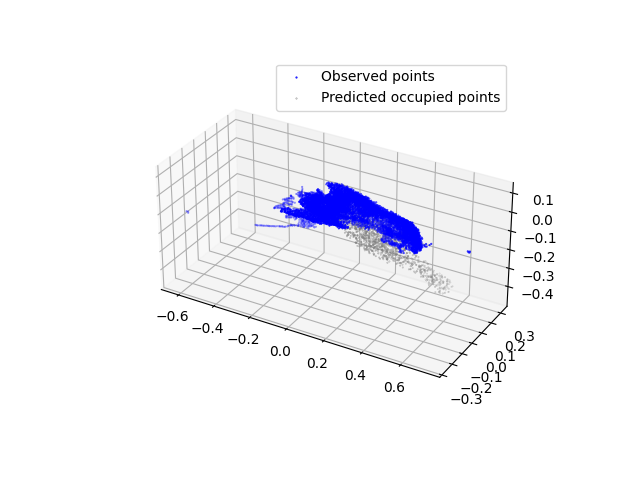

In [22]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.scatter(inputs_np[0, :, 0], inputs_np[0, :, 1], inputs_np[0, :, 2], 
            zdir='z', c= 'blue', s=0.3, label='Observed points')
ax1.scatter(points_pred[:, 0], points_pred[:, 1], points_pred[:, 2], 
            zdir='z', c= 'gray', s=0.1, label='Predicted occupied points')
ax1.set_aspect('equal')
ax1.legend()